<a href="https://colab.research.google.com/github/nwon24/basel/blob/main/Basel_LSTM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset,DataLoader,TensorDataset

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from datetime import date

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
file="/content/drive/MyDrive/Colab Notebooks/Basel_2020-23.csv"
file2="/content/drive/MyDrive/Colab Notebooks/Basel_2024-25.csv"
#file="/content/drive/MyDrive/Colab Notebooks/Basel_2001-25.csv"

df=pd.read_csv(file,delimiter=",",skiprows=10,usecols=[1],encoding="utf-8",header=None)
df2=pd.read_csv(file2,delimiter=",",skiprows=10,usecols=[1],encoding="utf-8",header=None)
nparr=df.to_numpy(dtype=np.float64)
nparr2=df2.to_numpy(dtype=np.float64)


In [17]:
nparr2.shape

(17544, 1)

In [20]:
predwin=8
testhours=365*24
horizon=8
totalhours=nparr.size
train_split=nparr[:-testhours]
test_split=nparr[-testhours:]
valid_split=nparr2


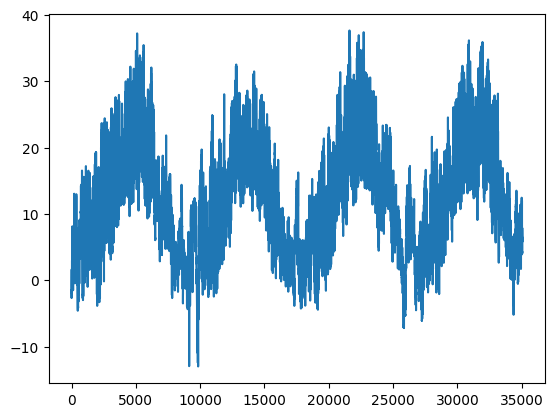

In [6]:
plt.plot(np.arange(totalhours),nparr)
plt.show()

In [21]:
scaler=MinMaxScaler(feature_range=(0,1))
#scaler=MinMaxScaler(feature_range=(-1,1))
train_data=(torch.from_numpy(scaler.fit_transform(train_split)))
test_data=(torch.from_numpy(scaler.transform(test_split)))
valid_data=(torch.from_numpy(scaler.transform(valid_split)))

In [26]:
def preparexy(data,predwin,horizon):
    n=(len(data)-predwin)//horizon
    x=torch.zeros((n,predwin,1))
    y=torch.zeros((n,horizon,1))
    for i in range(n):
        x[i]=data[i:i+predwin]
        y[i]=data[i+predwin:i+predwin+horizon]
    return x,y

xtrain,ytrain=preparexy(train_data,predwin,horizon)
xtest,ytest=preparexy(test_data,predwin,horizon)
xvalid,yvalid=preparexy(valid_data,predwin,horizon)

In [11]:
class lstm(nn.Module):
    def __init__(self,inputsize,hiddensize,nlayers,outputsize,batch_first=True,dropout=0.0):
        super().__init__()
        self.inputsize=inputsize
        self.hiddensize=hiddensize
        self.nlayers=nlayers
        self.batch_first=batch_first
        self.outputsize=outputsize
        self.dropout=dropout
        self.lstm=nn.LSTM(self.inputsize,self.hiddensize,self.nlayers,batch_first=self.batch_first,dropout=dropout)
        self.linear=nn.Linear(self.hiddensize,outputsize)

    def forward(self,x):
        out,_=self.lstm(x)
        return self.linear(out[:,-1,:])

In [27]:
inputsize=1
nlayers=1
hiddensize=128
outputsize=horizon

dropout=0.0
lr=1e-3

model=lstm(inputsize,hiddensize,nlayers,outputsize,dropout=dropout)
lossfn=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=lr)


In [28]:
batch_size=64
epochs=50

traindataset=TensorDataset(xtrain,ytrain)
trainloader=DataLoader(traindataset,batch_size=batch_size,shuffle=True)
testdataset=TensorDataset(xtest,ytest)
testloader=DataLoader(testdataset,batch_size=batch_size,shuffle=True)

In [36]:
print(xvalid.size(),yvalid.size())

torch.Size([2192, 8, 1]) torch.Size([2192, 8, 1])


In [64]:
def validate(model,xvalid,yvalid,shape,predwin,horizon,start=None,end=None):
    nhours=xvalid.numel()
    n=len(xvalid)
    t=np.arange(nhours)
    forecasts=[]
    for i in range(n):
        y=model(xvalid[i].reshape(shape))
        forecasts.append(y.detach().numpy())
    if end is None:
        end=nhours
    if start is None:
        start=0
    forecasts=np.array(forecasts).flatten()
    transformed_forecasts=scaler.inverse_transform(forecasts.reshape(-1,1))
    transformed_y=scaler.inverse_transform(yvalid.detach().numpy().reshape(-1,1))
    plt.figure()
    plt.plot(t[start:end],transformed_forecasts[start:end],label="Predicted")
    plt.plot(t[start:end],transformed_y[start:end],label="Actual")
    plt.legend(loc="best")
    plt.show()
    return r2_score(transformed_y[start:end],transformed_forecasts[start:end])

In [34]:
for epoch in range(epochs):
    model.train()
    trainloss=0.0
    testloss=0.0
    for x,y in trainloader:
        pred=model(x)
        loss=lossfn(pred,y.reshape(pred.shape))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        trainloss+=loss.item()

    model.eval()
    with torch.no_grad():
        for x,y in testloader:
            pred=model(x)
            loss=lossfn(pred,y.reshape(pred.shape))
            testloss+=loss.item()

    print(f"Epoch {epoch}: avg train loss = {trainloss/len(trainloader):.5f}, avg test loss = {testloss/len(testloader):.5f}")
    if (epoch+1)%5==0 and epoch>0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/Basel_LSTM_{date.today()}_{epoch}e_{nlayers}l.pth")


Epoch 0: avg train loss = 0.00395, avg test loss = 0.00205
Epoch 1: avg train loss = 0.00391, avg test loss = 0.00307


KeyboardInterrupt: 

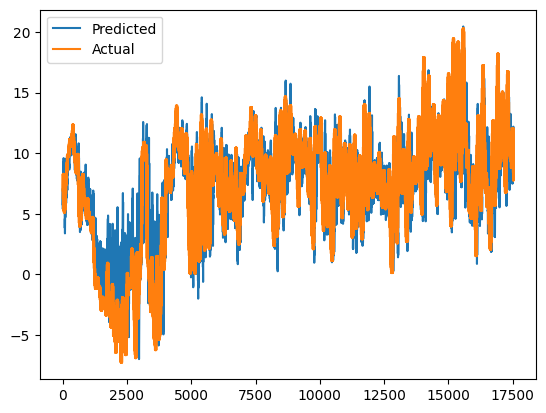

0.7243421077728271

In [65]:
validate(model,xvalid,yvalid,(1,-1,1),predwin,horizon,start=None,end=None)

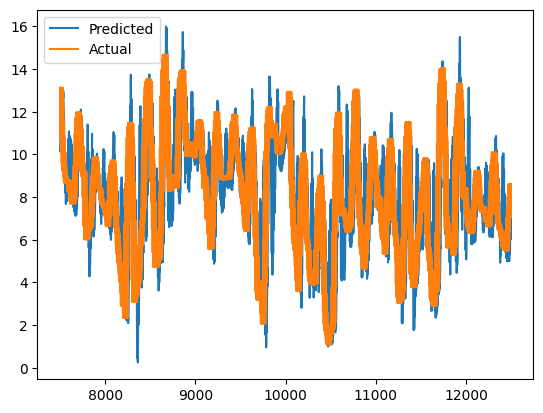

0.35459810495376587

In [66]:
validate(model,xvalid,yvalid,(1,-1,1),predwin,horizon,start=7500,end=12500)

In [ ]:
savepath=f"/content/drive/MyDrive/Colab Notebooks/Basel_LSTM_{epochs}e_{dropout}d.pth"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(),savepath)

In [ ]:
model.load_state_dict(torch.load(savepath,weights_only=True))

<All keys matched successfully>

In [ ]:
horizon=6
hist=xtest[-1].clone().detach()
forecasts=np.zeros(horizon)

for i in range(horizon):
    forecast=model(hist.reshape(1,-1,1))
    forecasts[i]=forecast.item()
    hist=hist.roll(shifts=-1)
    hist[-1]=forecast


In [ ]:
forecastx=np.arange(totalhours,totalhours+horizon)
plt.plot(forecastx,scaler.inverse_transform(forecasts.reshape(-1,1)))
plt.plot(np.arange(totalhours-testhours,totalhours),test_split)
plt.show()

In [ ]:
from sklearn.metrics import r2_score

model.eval()
with torch.no_grad():
    preds=torch.zeros(testhours-predwin)
    for i,x in enumerate(xtest):
        pred=model(x.reshape(1,-1,1))
        preds[i]=pred.item()

r2_scaled=r2_score(ytest.detach().numpy(),preds.detach().numpy())
#r2_unscaled=r2_score(scaler.inverse_transform(ytest.detach().numpy().reshape(-1,1)),
#                     scaler.inverse_transform(preds.detach().numpy().reshape(-1,1)))
print(f"r2 scaled score: {r2_scaled:.4f}")
#print(f"r2 unscaled score: {r2_unscaled:.4f}")

In [ ]:
horizon=len(xtest)
hist=xtest[0].clone().detach()
forecasts=np.zeros(horizon)

for i in range(horizon):
    forecast=model(hist.reshape(1,-1,1))
    forecasts[i]=forecast.item()
    #hist=hist.roll(shifts=-1)
    #hist[-1]=forecast
    hist=xtest[i].clone().detach()



In [ ]:
x=np.arange(totalhours-horizon,totalhours)
plt.plot(x,scaler.inverse_transform(forecasts.reshape(-1,1)))
plt.plot(x,test_split[predwin:])

plt.show()

NameError: name 'horizon' is not defined

In [ ]:
from sklearn.metrics import r2_score

horizon=100
hist=xtest[0].clone().detach()
forecasts=np.zeros(horizon)

for i in range(horizon):
    forecast=model(hist.reshape(1,-1,1))
    forecasts[i]=forecast.item()
    hist=hist.roll(shifts=-1)
    hist[-1]=forecast

print(f"r2 forecast score: {r2_score(test_split[predwin:predwin+horizon], scaler.inverse_transform(forecasts.reshape(-1,1)))}")

r2 forecast score: 0.45366685181088695


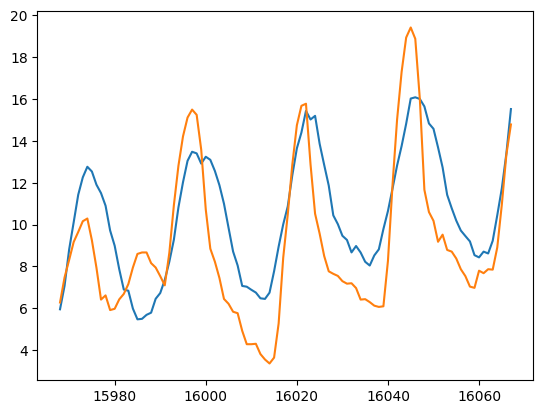

In [ ]:
x=np.arange(totalhours-testhours,totalhours-testhours+horizon)
plt.plot(x,scaler.inverse_transform(forecasts.reshape(-1,1)),label="predicted")
plt.plot(x,test_split[predwin:predwin+horizon],label="actual")

plt.show()

In [ ]:
def visualsubs(model,xtest,shape,predwin,horizon):
    hist=xtest[0].clone().detach()
    forecasts=np.zeros(horizon)

    for i in range(horizon):
        #hist=xtest[i].clone().detach()
        forecast=model(hist.reshape(shape))
        forecasts[i]=forecast.item()
        print(f"Forecast: {forecasts[i]}")
        print(f"Actual: {ytest[i]}")
        hist=hist.roll(shifts=-1)
        hist[-1]=forecast

    x=np.arange(totalhours-testhours,totalhours-testhours+horizon)
    plt.figure()
    plt.plot(x,scaler.inverse_transform(forecasts.reshape(-1,1)),label="predicted")
    plt.plot(x,test_split[predwin:predwin+horizon],label="actual")

    plt.legend(loc="best")
    plt.show()
    return r2_score(test_split[predwin:predwin+horizon], scaler.inverse_transform(forecasts.reshape(-1,1)))


In [ ]:
def visualisetest(model,xtest,shape,predwin):
    horizon=len(xtest)
    hist=xtest[0].clone().detach()
    forecasts=np.zeros(horizon)

    for i in range(horizon):
        hist=xtest[i].clone().detach()
        forecast=model(hist.reshape(shape))
        forecasts[i]=forecast.item()
        #hist=hist.roll(shifts=-1)
        #hist[-1]=forecast

    x=np.arange(totalhours-horizon,totalhours)
    plt.figure()
    plt.plot(x,scaler.inverse_transform(forecasts.reshape(-1,1)),label="predicted")
    plt.plot(x,test_split[predwin:],label="actual")
    plt.legend(loc="best")

    plt.show()
    return r2_score(test_split[predwin:], scaler.inverse_transform(forecasts.reshape(-1,1)))

In [ ]:
def validate(model,xtest,shape,predwin):
    horizon=len(xtest)
    hist=xtest[0].clone().detach()
    forecasts=np.zeros(horizon)

    for i in range(horizon):
        hist=xtest[i].clone().detach()
        forecast=model(hist.reshape(shape))
        forecasts[i]=forecast.item()
        #hist=hist.roll(shifts=-1)
        #hist[-1]=forecast

    x=np.arange(totalhours-horizon,totalhours)
    plt.figure()
    plt.plot(x,scaler.inverse_transform(forecasts.reshape(-1,1)),label="predicted")
    plt.plot(x,test_split[predwin:],label="actual")
    plt.legend(loc="best")

    plt.show()
    return r2_score(test_split[predwin:], scaler.inverse_transform(forecasts.reshape(-1,1))

Forecast: 0.15629228949546814
Actual: 0.17568311095237732
Forecast: 0.1535211205482483
Actual: 0.2290482223033905
Forecast: 0.15250907838344574
Actual: 0.2635246515274048
Forecast: 0.15237322449684143
Actual: 0.29213276505470276
Forecast: 0.15346384048461914
Actual: 0.31120482087135315
Forecast: 0.15592840313911438
Actual: 0.32275810837745667
Forecast: 0.15968814492225647
Actual: 0.32294148206710815
Forecast: 0.16467270255088806
Actual: 0.29470014572143555


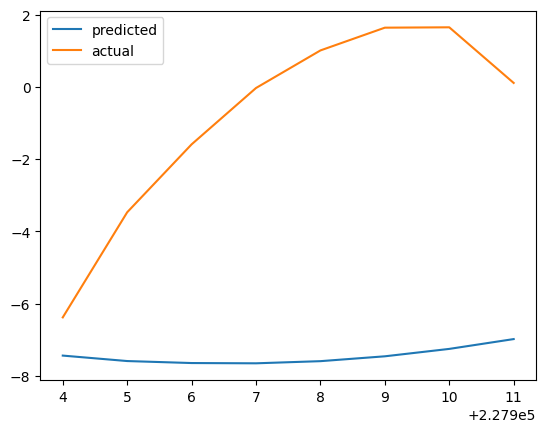

-6.192136684442892

In [ ]:
visualsubs(model,xtest,(1,-1,1),predwin,8)

In [ ]:
print(model(xtest[0].reshape(1,-1,1)))
print(ytest[0])


tensor([[0.3746]], grad_fn=<AddmmBackward0>)
tensor(0.3833)


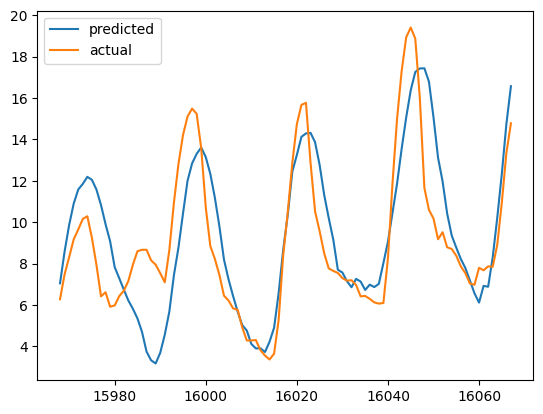

0.5617668256013222

In [ ]:
visualsubs(model,xtest,(1,-1,1),predwin)

Forecast: 0.3745877146720886
Actual: 0.3833371102809906
Forecast: 0.37095028162002563
Actual: 0.39335304498672485
Forecast: 0.36662036180496216
Actual: 0.40132027864456177


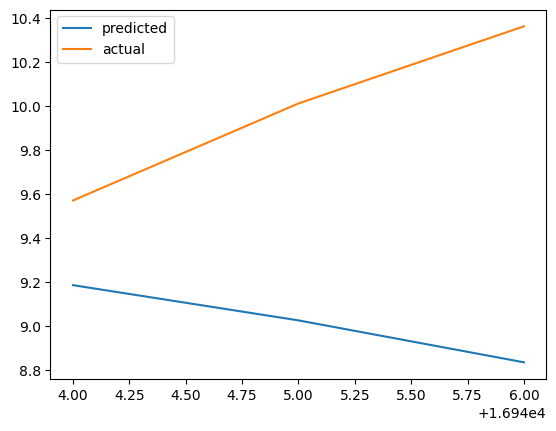

-9.976348507640925

In [ ]:
visualsubs(model,xtest,(1,-1,1),predwin,3)

In [67]:
!pip install pennylane
import pennylane as qml
#!pip install pennylane-lightning-gpu
#!pip install custatevec_cu12
#!pip install custatevec-cu11
#!pip install quimb


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 935.6/935.6 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 69.9 MB/s eta 0:00:00


In [ ]:
!python -m pip install pennylane pennylane-lightning pennylane-lightning-gpu --upgrade
!pip install custatevec-cu12

In [ ]:
!python -m pip install nvidia-cusparse-cu11 nvidia-cublas-cu11 nvidia-cuda-runtime-cu11 custatevec-cu11

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 997.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 17.4 MB/s eta 0:00:00


In [99]:
qpredwin=predwin
qhorizon=horizon
qoutputsize=outputsize
nqubits=qpredwin
#qdev="lightning.gpu"
#qdev="default.qubit"
qdev="lightning.qubit"
dev=qml.device(qdev,wires=nqubits)
#dev=qml.device("default.qubit",wires=nqubits)
nlayers=1

@qml.qnode(dev)
def qnode(inputs,weights):
    #print(inputs.shape)
    for i in range(nqubits):
        qml.Hadamard(wires=i)
        qml.RY(inputs[i],wires=i)
    #for i in range(len(inputs)):
    #    qml.RY(inputs[i],wires=i%nqubits)
    #qml.AmplitudeEmbedding(inputs,wires=range(nqubits),pad_with=0,normalize=True)

    for i in range(nlayers):
        for j in range(nqubits-1):
            qml.CNOT(wires=[j,j+1])
        qml.CNOT(wires=[0,nqubits-1])
        for j in range(nqubits):
            qml.Rot(*weights[i][j],wires=j)
    return [qml.expval(qml.PauliZ(i)) for i in range(nqubits)]

In [100]:
weightshapes={"weights": (nlayers,nqubits,3)}
qlayer=qml.qnn.TorchLayer(qnode,weightshapes)

In [101]:
class qmodel(nn.Module):
    def __init__(self,outputsize):
        super().__init__()
        self.qlayer=qlayer
        self.outputsize=outputsize
        self.lin=nn.Linear(nqubits,outputsize)

    def forward(self,x):
        y=self.qlayer(x)
        #print(y.shape)
        return self.lin(y)



In [102]:
qnn=qmodel(qoutputsize)

In [ ]:
qnn.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2026-01-28_44e_4l.pth",weights_only=True))

<All keys matched successfully>

In [103]:
qbatch_size=1
qxtrain,qytrain=preparexy(train_data,qpredwin,qhorizon)
qxtest,qytest=preparexy(test_data,qpredwin,qhorizon)
qtraindataset=TensorDataset(qxtrain,qytrain)
qlr=0.1
qtrainloader=DataLoader(qtraindataset,batch_size=qbatch_size,shuffle=True)
qtestdataset=TensorDataset(qxtest,qytest)
qtestloader=DataLoader(qtestdataset,batch_size=qbatch_size,shuffle=True)

In [104]:
qoptimizer=torch.optim.Adam(qnn.parameters(),lr=lr)

In [105]:
for epoch in range(epochs):
    qnn.train()
    trainloss=0.0
    testloss=0.0
    for x,y in qtrainloader:
        pred=qnn(x.flatten())
        #print(pred.shape)
        loss=lossfn(pred,y.reshape(pred.shape))
        qoptimizer.zero_grad()
        loss.backward()
        qoptimizer.step()
        trainloss+=loss.item()

    qnn.eval()
    with torch.no_grad():
        for x,y in qtestloader:
            pred=qnn(x.flatten())
            loss=lossfn(pred,y.reshape(pred.shape))
            testloss+=loss.item()

    print(f"Epoch {epoch}: avg train loss = {trainloss/len(trainloader):.5f}, avg test loss = {testloss/len(testloader):.5f}")
    if (epoch+1)%5==0 and epoch>0:
        torch.save(qnn.state_dict(), f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_{date.today()}_{epoch}e_{nlayers}l.pth")


Epoch 0: avg train loss = 1.32544, avg test loss = 0.66532
Epoch 1: avg train loss = 0.75052, avg test loss = 0.41805
Epoch 2: avg train loss = 0.68631, avg test loss = 0.33643
Epoch 3: avg train loss = 0.61681, avg test loss = 0.41514
Epoch 4: avg train loss = 0.54859, avg test loss = 0.39198
Epoch 5: avg train loss = 0.49718, avg test loss = 0.23114
Epoch 6: avg train loss = 0.44842, avg test loss = 0.32512
Epoch 7: avg train loss = 0.41413, avg test loss = 0.17535
Epoch 8: avg train loss = 0.39223, avg test loss = 0.27361
Epoch 9: avg train loss = 0.37451, avg test loss = 0.34304
Epoch 10: avg train loss = 0.36189, avg test loss = 0.42268
Epoch 11: avg train loss = 0.35792, avg test loss = 0.35253
Epoch 12: avg train loss = 0.34803, avg test loss = 0.27645
Epoch 13: avg train loss = 0.34245, avg test loss = 0.16036
Epoch 14: avg train loss = 0.33738, avg test loss = 0.17758
Epoch 15: avg train loss = 0.33433, avg test loss = 0.26360
Epoch 16: avg train loss = 0.33235, avg test loss 

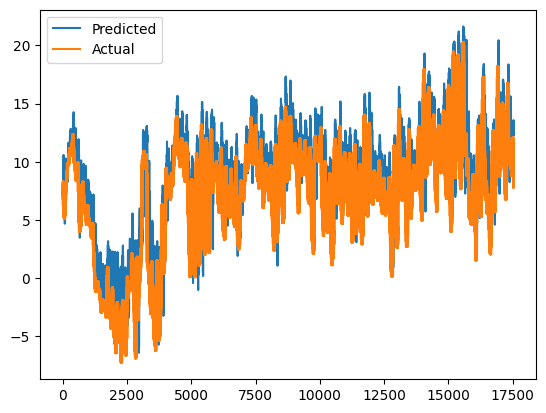

0.6783298254013062

In [79]:
# 4 layers
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

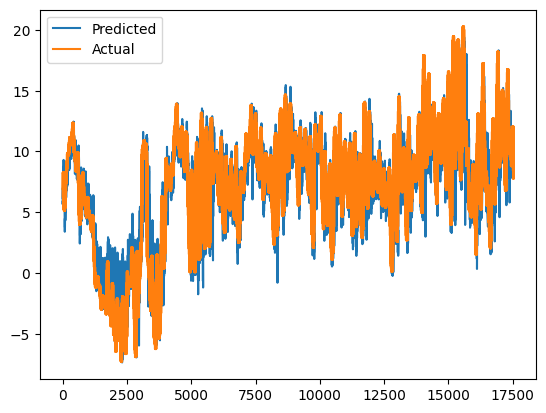

0.7588850855827332

In [89]:
# 3 layers
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

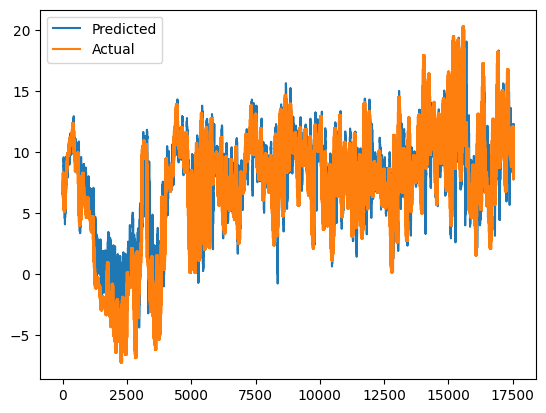

0.7253015041351318

In [97]:
# 2 layers
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

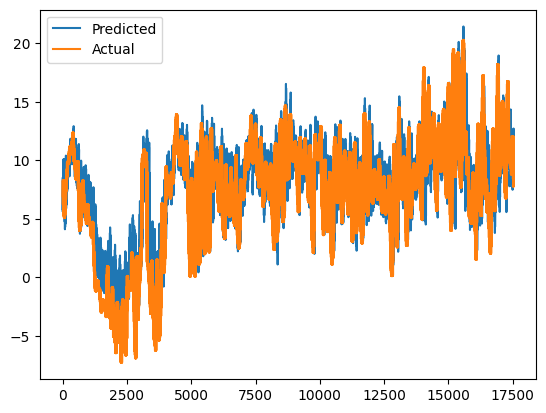

0.6514094471931458

In [107]:
# 1 layer
validate(qnn,xvalid,yvalid,(-1),qpredwin,qhorizon,start=None,end=None)

In [81]:
print(qnn(xvalid[0].reshape(-1)))
print(yvalid[0])

tensor([0.3913, 0.3973, 0.4051, 0.4069, 0.4110, 0.4137, 0.4141, 0.4164],
       grad_fn=<ViewBackward0>)
tensor([[0.3808],
        [0.3917],
        [0.4033],
        [0.4162],
        [0.4187],
        [0.4183],
        [0.4203],
        [0.4162]])


In [ ]:
    qsavepath=f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2201.pth"

In [ ]:
torch.save(qnn.state_dict(),f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_{date.today()}_{nlayers}l_lightning.pth")

In [ ]:
qnn.load_state_dict(torch.load(f"/content/drive/MyDrive/Colab Notebooks/Basel_QNN_2301.pth",weights_only=True))

<All keys matched successfully>

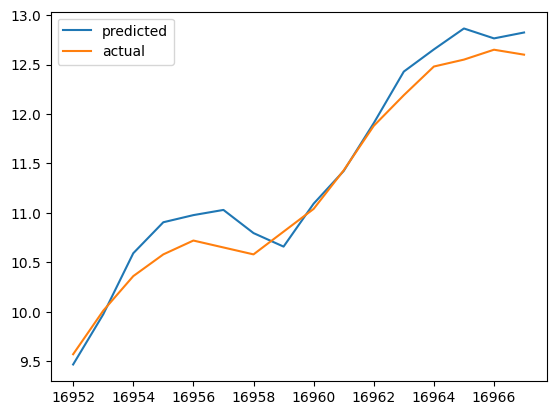

0.9537613050895613

In [ ]:
visualisetest(qnn,qxtest,(-1),qpredwin)

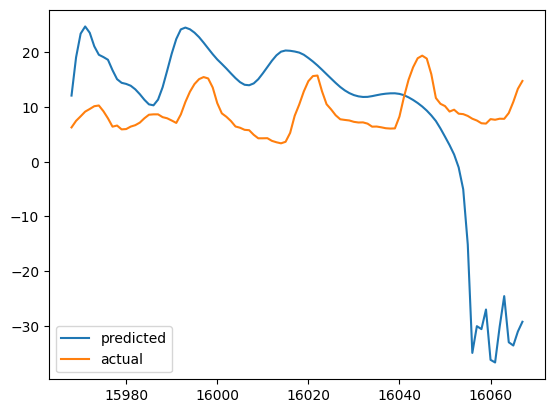

-20.406783413295717

In [ ]:
visualsubs(qnn,qxtest,(-1),qpredwin)